In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import sklearn.preprocessing as skp
import sklearn.pipeline as skpipe

In [2]:
ff_factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
ff_factors = ff_factors.loc[ff_factors.index >= 196311]
ff_factors = ff_factors.loc[ff_factors.index <= 201712]
portfolio_panel = pd.read_csv('25_Portfolios_5x5.CSV', skiprows=15, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)
portfolio_panel = portfolio_panel.loc[portfolio_panel.index >= 196311]
portfolio_panel = portfolio_panel.loc[portfolio_panel.index <= 201712]
portfolio370_panel = pd.read_csv('370portfolios.csv', skiprows=1, index_col=0,
                           engine='python', parse_dates=True, infer_datetime_format=True)


In [4]:
ff_factor_panel = ff_factors.to_numpy()
portfolio_return_panel = portfolio_panel.to_numpy() / 100 - ff_factor_panel[:, 3:4]/100
portfolio370_return_panel = portfolio370_panel.to_numpy() - ff_factor_panel[:, 3:4]/100

In [5]:
panel_evals, _ = np.linalg.eigh(portfolio_return_panel.dot(portfolio_return_panel.T))
panel_evals = panel_evals[::-1]

panel370_evals, _ = np.linalg.eigh(portfolio370_return_panel.dot(portfolio370_return_panel.T))
panel370_evals = panel370_evals[::-1]

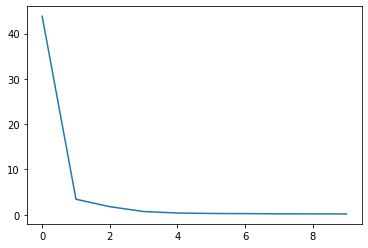

In [6]:
plt.plot(panel_evals[:10])

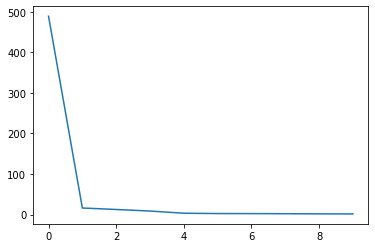

In [7]:
plt.plot(panel370_evals[:10])

In [8]:
def ic_1(N,T):
    NT = N*T
    N_plus_T = N+T
    # Make information critea penalties

    return np.log(NT/N_plus_T) * N_plus_T/NT

def l2_loss(N,T,data_panel, pred_data):
    return (1/(N*T))*np.sum(np.square(data_panel - pred_data))

def fit_bai_ng(data_panel, K):
#     pipe = skpipe.Pipeline([('Standardize', skp.StandardScaler(with_mean=True, with_std=True)),
#                             ('Factors', skd.TruncatedSVD(K, algorithm='arpack'))])
    pipe = skpipe.Pipeline([('Factors', skd.TruncatedSVD(K, algorithm='arpack'))])

    F = pipe.fit_transform(data_panel)
    lmbda = np.linalg.lstsq(F,data_panel, rcond=None)[0]
#     data_hat_last = pipe.inverse_transform(F)
    data_hat_last = F.dot(lmbda)
#     assert np.allclose(data_hat_last, F.dot(lmbda)), np.max(np.abs(data_hat_last - F.dot(lmbda)))
    return F, lmbda, data_hat_last

def bai_ng_ev_criterion(data_panel, ic_func, max_evs=15):
    T, N = data_panel.shape
    penalized_function_resuls = []
    for i in range(1, max_evs + 1):
        F, lmbda, pred_panel = fit_bai_ng(data_panel, i)
        penalized_function_resuls.append(np.log(l2_loss(N,T,data_panel, pred_panel)) + i*ic_func(N,T))
    return penalized_function_resuls

def ahn_horenstein_evr(data_panel, max_evs=15):
    T, N = data_panel.shape
    means = np.mean(data_panel, axis=1, keepdims=True)
    evals, _ = np.linalg.eigh(data_panel.dot(data_panel.T) - means.dot(means.T)) 
    evals = evals[::-1][:max_evs]
    ratios = [x / y for x,y in zip(evals[:-1], evals[1:])]
    return ratios
    
def fit_rp_pca(data_panel, K, gamma):
    T, N = data_panel.shape
#     std_pipe = skpipe.Pipeline([('Standardize', skp.StandardScaler(with_mean=True, with_std=True))])
    fit_pipe = skpipe.Pipeline([('loadings', skd.TruncatedSVD(K, algorithm='arpack'))])
    
    r_bar = np.mean(data_panel, axis=0, keepdims=True)
    objective  = (1/(N*T))*data_panel.T.dot(data_panel) + (gamma/T)*r_bar.T.dot(r_bar)
    
    lmbda = fit_pipe.fit_transform(objective)
    print(lmbda.shape, data_panel.shape)
    F =  np.linalg.lstsq(lmbda, data_panel.T, rcond=None)[0]
    
    return F.T, lmbda.T


4


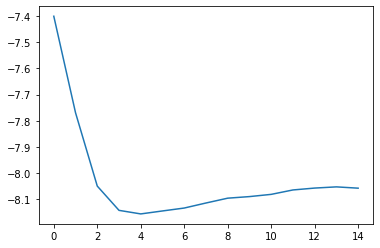

In [9]:
by_factor_ic = bai_ng_ev_criterion(portfolio_return_panel, ic_1)
print(np.argmin(by_factor_ic))
plt.plot(by_factor_ic)    

12


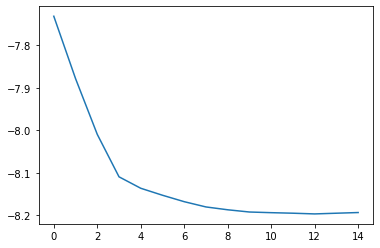

In [10]:
by_factor_ic = bai_ng_ev_criterion(portfolio370_return_panel, ic_1)
print(np.argmin(by_factor_ic))
plt.plot(by_factor_ic)

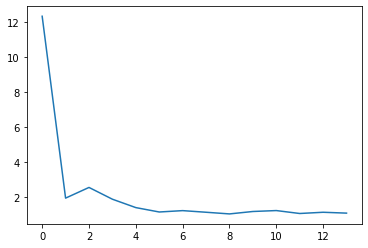

In [11]:
byf_factor_evr = ahn_horenstein_evr(portfolio_return_panel)
plt.plot(byf_factor_evr)

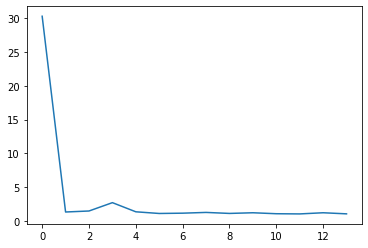

In [12]:
byf_factor_evr = ahn_horenstein_evr(portfolio370_return_panel)
plt.plot(byf_factor_evr)

### 4

In [13]:
pca_factors_25, pca_loadings_25, _ = fit_bai_ng(portfolio_return_panel, 3)
pca_factors_370, pca_loadings_370, _ = fit_bai_ng(portfolio370_return_panel, 5)

### 5

In [14]:
rp_pca_factors_25, rp_pca_loadings_25 = fit_rp_pca(portfolio_return_panel, 3, gamma=20)
rp_pca_factors_370, rp_pca_loadings_370 = fit_rp_pca(portfolio370_return_panel, 5, gamma=20)

(25, 3) (650, 25)
(370, 5) (650, 370)


### 6

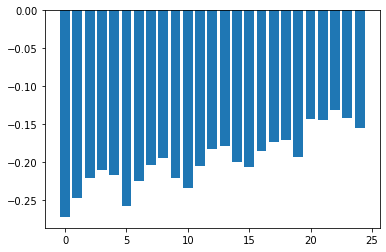

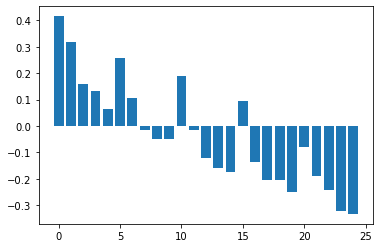

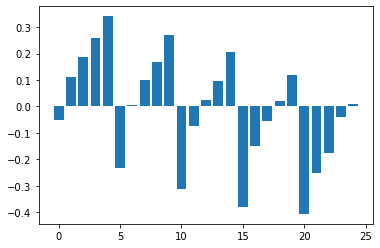

In [15]:
for i in range(3):
    plt.bar(np.arange(25), pca_loadings_25[i])
    plt.show()

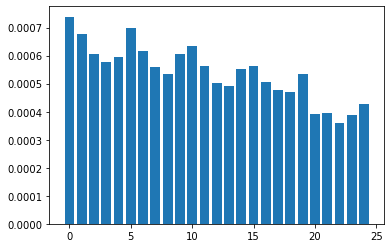

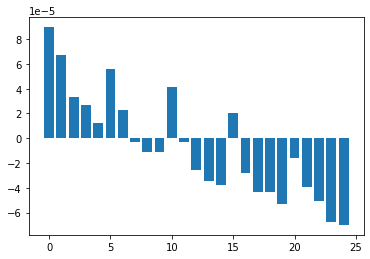

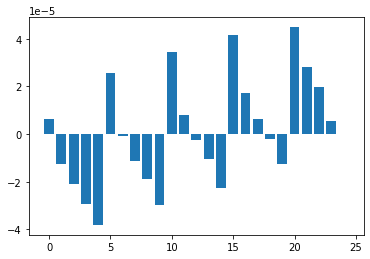

In [16]:
for i in range(3):
    plt.bar(np.arange(25), rp_pca_loadings_25[i])
    plt.show()

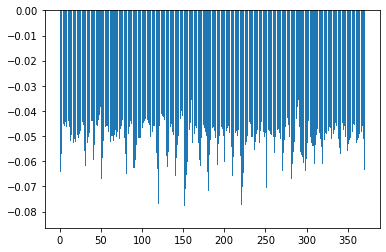

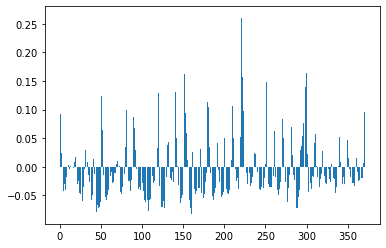

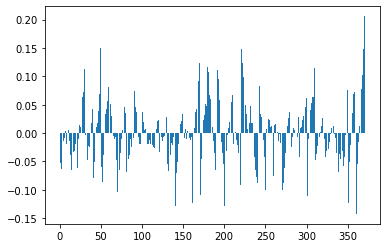

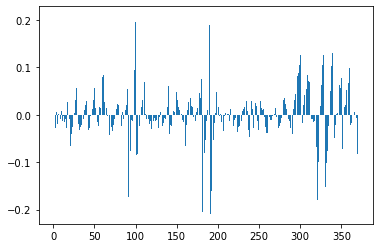

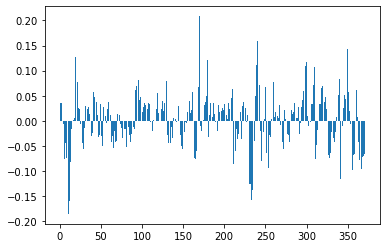

In [17]:
for i in range(5):
    plt.bar(np.linspace(1, 370, 370), pca_loadings_370[i])
    plt.show()

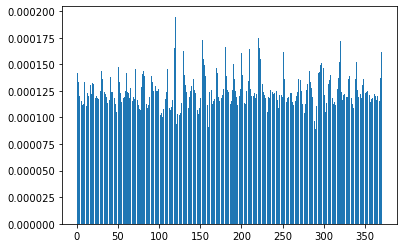

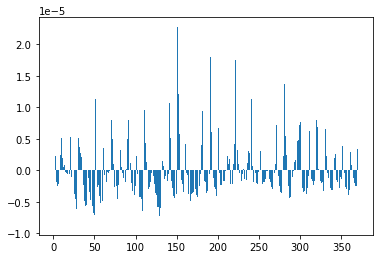

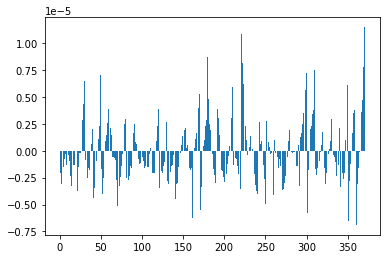

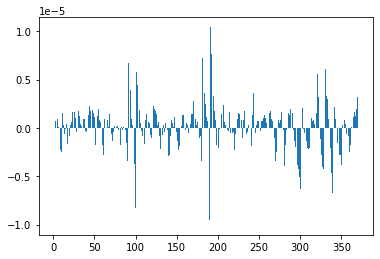

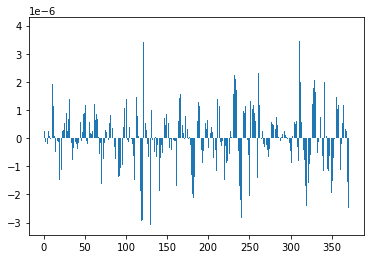

In [18]:
for i in range(5):
    plt.bar(np.linspace(1, 370, 370), rp_pca_loadings_370[i])
    plt.show()

### 7

In [19]:
def sharpe(series):
    return np.mean(series) / np.std(series)


def sharpe_factors(factors_t_n):
    mu_f = np.mean(factors_t_n, axis=0, keepdims=True)
    return np.sqrt(mu_f.dot(np.linalg.inv(np.cov(factors_t_n.T))).dot(mu_f.T))

def markowitz(panel_t_n):
    T,N = panel_t_n.shape
    mu = np.mean(panel_t_n, axis=0, keepdims=True)
    
    cov = np.cov(panel_t_n.T)
    if N > 1:
        return np.linalg.inv(cov).dot(mu.T)
    else:
        return mu.T / cov

def sharpe_of_factors(factors):
    portfolio = markowitz(factors)
    return sharpe(factors.dot(portfolio))

In [20]:
sharpe_of_factors(ff_factor_panel[:,0:1])

0.11964372062827071

In [21]:
sharpe_of_factors(ff_factor_panel[:,0:3]),  sharpe_factors(ff_factor_panel[:,0:3])

(0.20744383051050613, array([[0.2072842]]))

In [22]:
sharpe_of_factors(pca_factors_25),  sharpe_factors(pca_factors_25)

(0.22056404712737923, array([[0.22039432]]))

In [23]:
sharpe_of_factors(rp_pca_factors_25),  sharpe_factors(rp_pca_factors_25)

(0.22205052342317022, array([[0.22187965]]))

In [24]:
sharpe_of_factors(pca_factors_370),  sharpe_factors(pca_factors_370)

(0.2696999179073332, array([[0.26949238]]))

In [25]:
sharpe_of_factors(rp_pca_factors_370),  sharpe_factors(rp_pca_factors_370)

(0.5776785637533003, array([[0.57723402]]))

###  8

In [42]:
def time_series_ap_test(factors, test_assets):
    T, N = test_assets.shape
    _, K = factors.shape
    ones_T = np.ones((T,1))
    loadings = np.linalg.lstsq(np.concatenate([ones_T, factors], axis=1),
                    test_assets, rcond=None)[0]
    alphas = loadings[0:1, :]
    betas = loadings[1:, :]
    
    residuals = test_assets - np.concatenate([ones_T, factors], axis=1).dot(loadings)
    mu_t = np.mean(factors, axis=0, keepdims=True)
    omega = (1/T)*sum([(factors[t:t+1,:] - mu_t).T.dot(factors[t:t+1,:] - mu_t) for t in range(T)])
    
    sigma_hat = (1/T)*(sum([residuals[t:t+1].T.dot(residuals[t:t+1]) for t in range(T)])) * np.eye(N)
    
    fscore = ((T - N - K) / N) * (1/(1 + mu_t.dot(np.linalg.inv(omega)).dot(mu_t.T))) * \
        (alphas.dot(np.linalg.inv(sigma_hat)).dot(alphas.T))
    return fscore, N, T - N - K
    

In [43]:
from scipy.stats import f

In [44]:
score, df1, df2 = time_series_ap_test(ff_factor_panel[:,0:1], portfolio_return_panel)
rv = f(df1, df2)
score, df1, df2, 1-rv.cdf(score)

(array([[5.68725613]]), 25, 624, array([[3.33066907e-16]]))

In [45]:
score, df1, df2 = time_series_ap_test(ff_factor_panel[:,0:3], portfolio_return_panel)
rv = f(df1, df2)
score, df1, df2, 1-rv.cdf(score)

(array([[3.75673987]]), 25, 622, array([[4.06756739e-09]]))

In [46]:
score, df1, df2 = time_series_ap_test(pca_factors_25, portfolio_return_panel)
rv = f(df1, df2)
score, df1, df2, 1-rv.cdf(score)

(array([[4.56430073]]), 25, 622, array([[4.61397587e-12]]))

In [47]:
score, df1, df2 = time_series_ap_test(rp_pca_factors_25, portfolio_return_panel)
rv = f(df1, df2)
score, df1, df2, 1-rv.cdf(score)

(array([[4.52939293]]), 25, 622, array([[6.20403728e-12]]))

In [48]:
score, df1, df2 = time_series_ap_test(pca_factors_370, portfolio370_return_panel)
rv = f(df1, df2)
score, df1, df2, 1-rv.cdf(score)

(array([[1.68784191]]), 370, 275, array([[2.60111561e-06]]))

In [49]:
score, df1, df2 = time_series_ap_test(rp_pca_factors_370, portfolio370_return_panel)
rv = f(df1, df2)
score, df1, df2, 1 - rv.cdf(score)

(array([[1.26146802]]), 370, 275, array([[0.02058288]]))

###  9

In [68]:
def xs_ap_test(factors, test_assets):
    T, N = test_assets.shape
    _, K = factors.shape
    ones_T = np.ones((T,1))
    loadings = np.linalg.lstsq(np.concatenate([ones_T, factors], axis=1),
                    test_assets, rcond=None)[0]
    a_s = loadings[0:1, :]
    betas = loadings[1:, :]
    
    Sigma_F = np.cov(factors.T)

    expected_returns = np.mean(test_assets, axis=0)
    ones_N = np.ones((N,1))
    lambdas = np.linalg.lstsq(betas.T, expected_returns.T, rcond=None)[0]
    alphas = expected_returns.T - betas.T.dot(lambdas)
    print(np.linalg.norm(alphas))
    
    Sigma = np.eye(N) * alphas.dot(alphas.T)
    
    in_minus_beta = np.eye(N) - betas.T.dot(np.linalg.inv(betas.dot(betas.T))).dot(betas)
    
    shanken_correction = 1 + lambdas.T.dot(np.linalg.inv(Sigma_F)).dot(lambdas)
    
    cov_alpha = (1/T) * in_minus_beta.dot(Sigma).dot(in_minus_beta.T) * shanken_correction
    score = alphas.T.dot(cov_alpha).dot(alphas)
    return score, N - 1
    

In [52]:
from scipy.stats.distributions import chi2

In [53]:
xs_ap_test(ff_factor_panel[:,0:1], portfolio_return_panel)

0.012470604237683959


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [54]:
score, df = xs_ap_test(ff_factor_panel[:,0:3], portfolio_return_panel)
rv = chi2(df)
score, df, 1-rv.cdf(score)

0.006964465565106855


(3.795729455228653e-12, 24, 1.0)

In [55]:
score, df = xs_ap_test(pca_factors_25, portfolio_return_panel)
rv = chi2(df)
score, df, 1-rv.cdf(score)

0.006611505525942679


(3.0802059559441538e-12, 24, 1.0)

In [56]:
score, df = xs_ap_test(rp_pca_factors_25, portfolio_return_panel)
rv = chi2(df)
score, df, 1-rv.cdf(score)

0.006584986897440249


(3.031425663801067e-12, 24, 1.0)

In [58]:
score, df = xs_ap_test(pca_factors_370, portfolio370_return_panel)
rv = chi2(df)
score, df, 1-rv.cdf(score)

0.027022414706778124


(8.731461397701235e-10, 369, 1.0)

In [59]:
score, df = xs_ap_test(rp_pca_factors_370, portfolio370_return_panel)
rv = chi2(df)
score, df, 1-rv.cdf(score)

0.021307600334909853


(3.628215427199873e-10, 369, 1.0)

###  10

In [60]:
mkt_loadings = np.linalg.lstsq(ff_factor_panel[:,0:1], portfolio_return_panel, rcond=None)[0]

In [61]:
ff_25_loadings = np.linalg.lstsq(ff_factor_panel[:,0:3], portfolio_return_panel, rcond=None)[0]

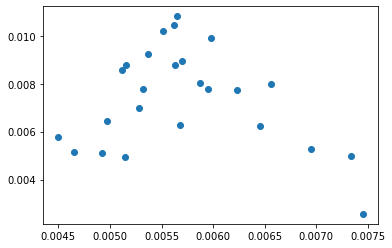

In [62]:
plt.scatter(np.mean(ff_factor_panel[:,0:1], axis=0, keepdims=True).dot(mkt_loadings).flatten(), 
            np.mean(portfolio_return_panel, axis=0, keepdims=True).flatten())

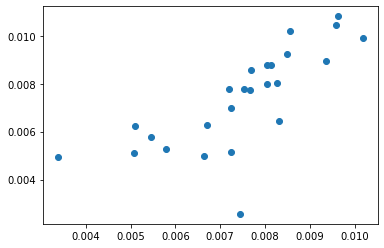

In [63]:
plt.scatter(np.mean(ff_factor_panel[:,0:3], axis=0, keepdims=True).dot(ff_25_loadings).flatten(), 
            np.mean(portfolio_return_panel, axis=0, keepdims=True).flatten())

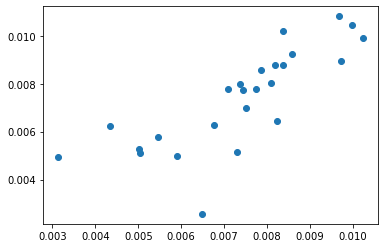

In [64]:
plt.scatter(np.mean(pca_factors_25, axis=0, keepdims=True).dot(pca_loadings_25).flatten(), 
            np.mean(portfolio_return_panel, axis=0, keepdims=True).flatten())

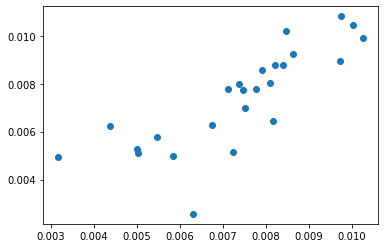

In [65]:
plt.scatter(np.mean(rp_pca_factors_25, axis=0, keepdims=True).dot(rp_pca_loadings_25).flatten(), 
            np.mean(portfolio_return_panel, axis=0, keepdims=True).flatten())

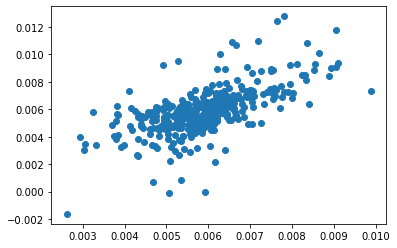

In [66]:
plt.scatter(np.mean(pca_factors_370, axis=0, keepdims=True).dot(pca_loadings_370).flatten(), 
            np.mean(portfolio370_return_panel, axis=0, keepdims=True).flatten())

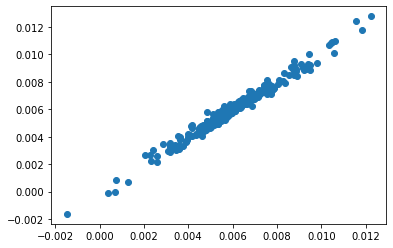

In [67]:
plt.scatter(np.mean(rp_pca_factors_370, axis=0, keepdims=True).dot(rp_pca_loadings_370).flatten(), 
            np.mean(portfolio370_return_panel, axis=0, keepdims=True).flatten())